In [1]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [5]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    return cleaned_sent

In [6]:
X_train = olid_data.tweet
y_train = pd.factorize(olid_data.subtask_a)[0]

X_test=pd.read_csv('data/OLIDv1/testset-levela.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levela.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')


X train shape: (13240,), y train shape: (13240,)


Splitting data into train, test and hold out sets.
Our split will be 80% train, 10% validation and 10% test

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (10592,), y train shape: (10592,)
X valid shape: (2648,), y valid shape: (2648,)
X valid shape: (860,), y test shape: (860,)


Data preprocessing. 

In [8]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [9]:
data_train[0], data_valid[0], data_test[0]

('leaving bb',
 'john kerry running mouth cared ha say think single damn thing kerry ha accomplished besides run mouth . trump accomplishment exceed anything kerry could ever dream of . even becoming president',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

Create a vocabulary with UNK token for out of vocabulary words

In [10]:
vocab_size = 10000
embedding_size = 100
lstm_output_dim = 32
max_length = 280
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)


In [12]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_length))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, nlayers = 100, return_sequences = True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 1.5196556671449069, 1: 0.7451808076544252}

In [30]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience=5,restore_best_weights=True )
n_epochs = 15

In [31]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid))

Epoch 1/15
83/83 - 15s - loss: 0.6934 - accuracy: 0.5173 - val_loss: 0.6914 - val_accuracy: 0.6428
Epoch 2/15
83/83 - 13s - loss: 0.6917 - accuracy: 0.5006 - val_loss: 0.6825 - val_accuracy: 0.6587
Epoch 3/15
83/83 - 13s - loss: 0.5641 - accuracy: 0.7809 - val_loss: 0.6041 - val_accuracy: 0.7325
Epoch 4/15
83/83 - 13s - loss: 0.4867 - accuracy: 0.8344 - val_loss: 0.6041 - val_accuracy: 0.6803
Epoch 5/15
83/83 - 13s - loss: 0.4494 - accuracy: 0.8492 - val_loss: 0.6443 - val_accuracy: 0.7268
Epoch 6/15
83/83 - 13s - loss: 0.3835 - accuracy: 0.8806 - val_loss: 0.6462 - val_accuracy: 0.7359
Epoch 7/15
83/83 - 13s - loss: 0.3450 - accuracy: 0.8984 - val_loss: 0.6839 - val_accuracy: 0.7370
Epoch 8/15
83/83 - 13s - loss: 0.3826 - accuracy: 0.8919 - val_loss: 0.6562 - val_accuracy: 0.7355
Epoch 9/15
83/83 - 13s - loss: 0.3365 - accuracy: 0.9104 - val_loss: 0.7186 - val_accuracy: 0.7299
Epoch 10/15
83/83 - 13s - loss: 0.3127 - accuracy: 0.9181 - val_loss: 0.6931 - val_accuracy: 0.7395
Epoch 11/

In [32]:
model_trained.history

{'loss': [0.6934375762939453,
  0.6916847229003906,
  0.5641363263130188,
  0.48666733503341675,
  0.449430376291275,
  0.3834884464740753,
  0.34502872824668884,
  0.3826279640197754,
  0.3364546000957489,
  0.31274041533470154,
  0.34021586179733276,
  0.31293055415153503,
  0.2828274071216583,
  0.2650972306728363,
  0.2567100524902344],
 'accuracy': [0.517292320728302,
  0.5005843043327332,
  0.7808936834335327,
  0.8343517184257507,
  0.8491592407226562,
  0.8805890679359436,
  0.8983724117279053,
  0.8919001817703247,
  0.9104430675506592,
  0.9181154370307922,
  0.8908213973045349,
  0.9079349040985107,
  0.9239828586578369,
  0.9307944178581238,
  0.934777557849884],
 'val_loss': [0.6913880705833435,
  0.6824870109558105,
  0.6040786504745483,
  0.6041038036346436,
  0.6442578434944153,
  0.6461570262908936,
  0.6839406490325928,
  0.6561804413795471,
  0.7186309695243835,
  0.6931100487709045,
  0.7403952479362488,
  0.7470789551734924,
  0.8131627440452576,
  0.81042146682739

Text(0, 0.5, 'Accuracy')

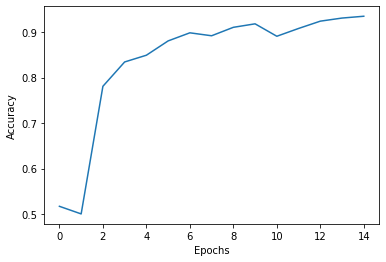

In [35]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

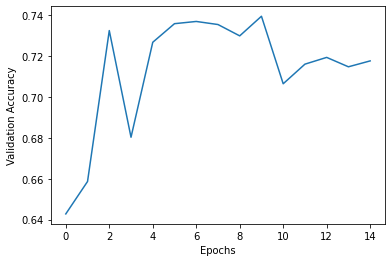

In [36]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [37]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.evaluate(test_padded,y_test))


27/27 [==============================] - 0s 17ms/step - loss: 0.6790 - accuracy: 0.7657
[0.6789915561676025, 0.7656935453414917]


In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred_bool>0.5)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.25      0.16      0.19       240
           1       0.72      0.82      0.76       620

    accuracy                           0.63       860
   macro avg       0.48      0.49      0.48       860
weighted avg       0.59      0.63      0.61       860

